<a href="https://colab.research.google.com/github/avinashkumar18/Lab/blob/main/Deep%20Learning/Assessment%206/auto_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Import packages
import tarfile
import tqdm
import cv2
import os
import pandas as pd
import numpy as np

In [2]:
# 2. Import datasets
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2021-05-21 15:18:42--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-05-21 15:18:42--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

lfw_attributes.txt  100%[===================>]  14.19M  33.3MB/s    in 0.4s    

2021-05-21 15:18:43 (33.3 MB/s) - ‘lfw_attributes.txt’ saved [14879205/14879205]

--2021-05-21 15:18:43--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu

In [3]:
# 3. Copy the path of datasets
attribute_name = "/content/lfw_attributes.txt"
image_name = "/content/lfw-deepfunneled.tgz"
raw_image_name = "/content/lfw.tgz"

In [4]:
# 4. function to convert color image into RGB format
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [5]:
# 5. function to extract dataset and return image with its corresponding attribute name

def load_lfw_dataset( use_raw=False, dx=80, dy=80, dimx=45, dimy=45 ):
    
    # Read attribute names and its corresponding image vector value
    df_attrs = pd.read_csv(attribute_name, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(raw_image_name if use_raw else image_name) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            # as we need only image files for this model
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                #calling the function to convert into RGB format
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [6]:
# 6. Get the image and its corresponding attribute
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [7]:
# 7. Normalizing image values
X = X.astype('float32') / 255.0 - 0.5

In [8]:
# 8. we can see that image value lies between -.5 to .5
print(X.max(), X.min())

0.5 -0.5


In [9]:
# 9. function to display sample images
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

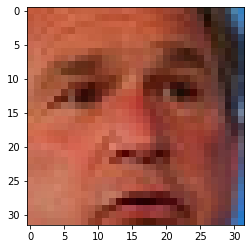

In [10]:
# 10. sample image
import random
show_image(X[random.randint(1,1000)])

In [11]:
# 11. Splitting train and test set
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [12]:
# 12. Here, we build the models for encoder and decoder 
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [13]:
# 13. calling the autoencoder function with required parameters
IMG_SHAPE = X.shape[1:]
#code size is 32, this may give image with more loss in pixels
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)


inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32)                98336     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         101376    
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# 14. model.fit is used for the dataset
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,validation_data=(X_test, X_test))

Epoch 1/20
370/370 [==============================] - 3s 6ms/step - loss: 0.0205 - val_loss: 0.0103
Epoch 2/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0097 - val_loss: 0.0082
Epoch 3/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 4/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 5/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 6/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 7/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
370/370 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0066

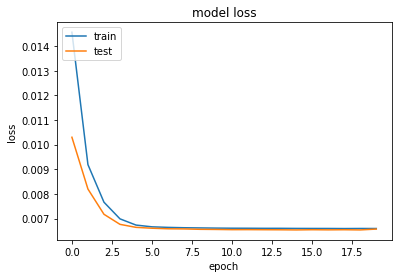

In [15]:
# 15. Visualizing the loss vs epoch for train and test sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

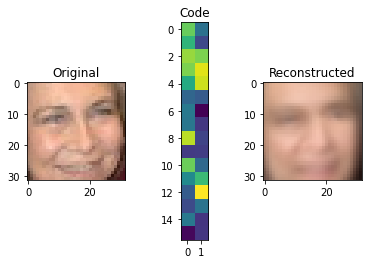

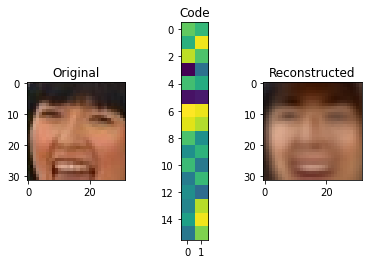

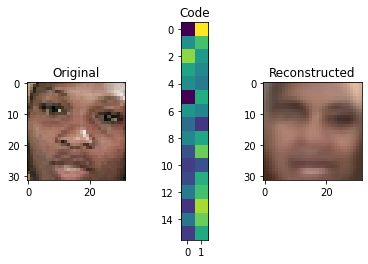

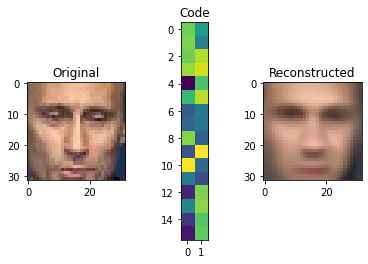

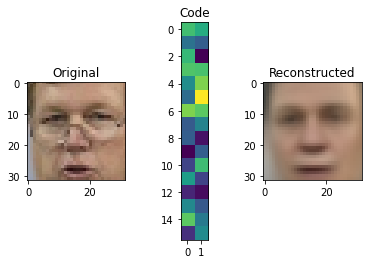

In [16]:
# 16. Displaying few original and reconstructed
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

Above we see lots of data compression. Now let us run above cells with code_size of 1000

In [17]:
# 17. Perform Denoising. This removes noise from image
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

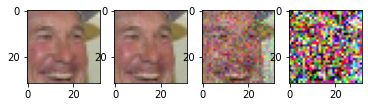

In [18]:
# 18 Plotting with noise
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [19]:
# 19. Perform same model for removing noise
code_size = 1000

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,validation_data=(X_test_noise, X_test))

Epoch 1/25, Generating corrupted samples...
370/370 [==============================] - 23s 62ms/step - loss: 0.0214 - val_loss: 0.0083
Epoch 2/25, Generating corrupted samples...
370/370 [==============================] - 23s 62ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 3/25, Generating corrupted samples...
370/370 [==============================] - 23s 62ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 4/25, Generating corrupted samples...
370/370 [==============================] - 23s 62ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 5/25, Generating corrupted samples...
370/370 [==============================] - 23s 62ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/25, Generating corrupted samples...
370/370 [==============================] - 24s 64ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/25, Generating corrupted samples...
370/370 [==============================] - 24s 65ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 8/25, Generating corrupted samples...
370/370 [==

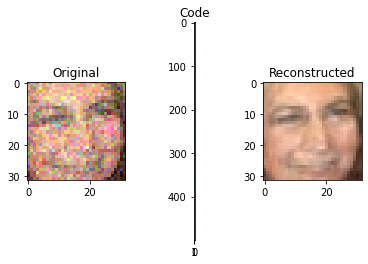

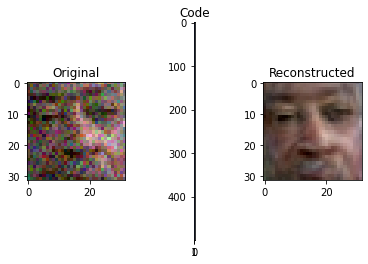

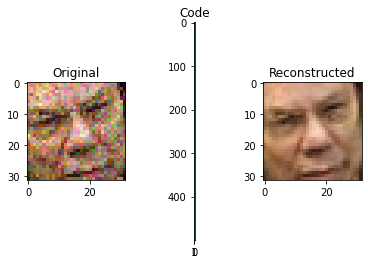

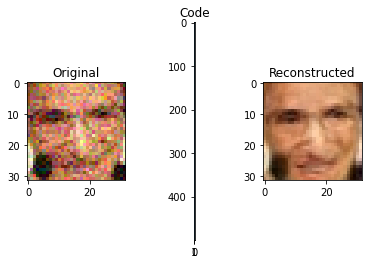

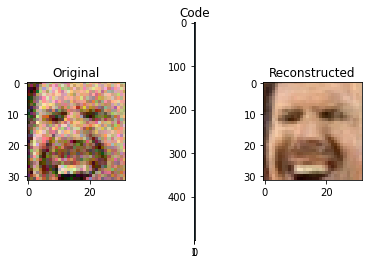

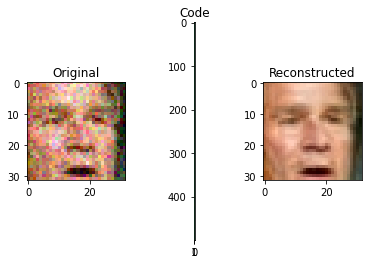

In [20]:
# 20. Displaying noise and reconstructed images
X_test_noise = apply_gaussian_noise(X_test)
for i in range(6):
    img = X_test_noise[i*225]
    visualize(img,encoder,decoder)